# Simple A/B Testing with Python

Pada notebook ini, kita akan mencoba menganalisis menggunakan A/B test, dari memformulasikan hipotesis, mengujinya, dan mengintepretasikan hasilnya. Data yang digunakan <a href='https://www.kaggle.com/zhangluyuan/ab-testing?select=ab_data.csv'>dataset dari Kaggle</a> yang berisi hasil A/B test dari 2 desain halaman website yang berbeda (old_page vs new_page). Hal yang akan kita lakukan sebagai berikut:

1. Desain eksperimen
2. Mengumpulkan dan mempersiapkan data
3. Visualisasi Data
4. Uji Hipotesis
5. Menarik kesimpulan

Skenario yang ingin diuji pada analisis ini dapat dicontohkan sebagai berikut:

> Bayangkan kita bekerja pada tim produk suatu bisnis e-commerce online. UX designer telah bekerja untuk membuat versi baru dari halaman website dari produk kita dengan harapan conversion rate-nya akan naik.PM memberitahu bahwa conversion rate saat ini sebesar 11% secara rata-rata dalam setahun dan tim berkespektasi dengan adanya kenaikan 3%. Artinya desain baru akan dipertimbangkan apabila dapat menaikkan conversion rate hingga 14%

Sebelum meluncurkan perubahan, tim akan mengujinya pada sejumlah kecil pengguna untuk melihat kinerjanya, jadi A/B testing akan diuji pada subset dari dataset.

***
## 1. Desain Eksperimen

### Formulasi Hipotesis


Hal pertama, kita ingin memastikan bahwa kita perlu merumuskan hipotesis di awal proyek. Proses ini akan memastikan interpretasi kita terhadap hasilnya benar dan tepat.

Tugas yang diberikan kita untuk mengetahui apakah desain baru memiliki performa yang lebih baik, lebih buruk, atau sama. Untuk itu, kita akan memilih <a href="https://en.wikipedia.org/wiki/One-_and_two-tailed_tests">**two-tailed test**</a>:

$$H_0: p = p_0$$
$$H_a: p \ne p_0$$

dimana $p$ dan $p_0$ secara berturut-turut berarti conversion rate dari the new and old design. Kita juga mengatur confidence level sebesar 95%:

$$\alpha = 0.05$$

Nilai $\alpha$ adalah ambang batas yang kita atur, yang berarti "jika probabilitas dari hasil yang diobservasi ($p$-value) kurang dari $\alpha$, maka null hypothesis ditolak". Karena nilai yang diatur $\alpha=0.05$, tingkat keyakinan kita (1 - $\alpha$) adalah 95%.

### Memilih Variabel

Pada pengujian yang dilakukan, kita membutuhkan 2 grup:
* Grup kontrol - old design
* Grup perlakuan - new design

Ini merupakan variabel independen pada pengujian ini. Variabel lain selain desain halaman produk dijaga agar tetap sama. Hal ini dikarenakan kita ingin langsung membandingkan antara dua grup yang berbeda secara langsung. Apabila variabel lain tidak dijaga tetap sama (misal waktu pengujian, level pengguna, promosi), maka kita tidak dapat memastikan variabel mana yang mempengaruhi conversion rate. Oleh karena itu, perbedaan sistematis yang diuji pada pengujian ini hanya terletak pada desain website.

Variabel terikat pada pengujian ini adalah conversion rate, yang dilambangkan sebagai berikut:
* `0` - Pengguna tidak membeli produk selama sesi ini
* `1` - Pengguna membeli produk selama sesi ini

### Pemilihan Ukuran Sampel

Pada pengujian ini, ukuran sampel minimal dicoba, tidak menggunakan keseluruhan dataset. Oleh karena itu, conversion rates yang kita dapat akan berupa estimasi.

Jumlah orang (atau sesi pengguna) yang dipuyuskan untuk dicatat di setiap grup akan memengaruhi ketepatan taksiran rasio konversi: semakin besar ukuran sampel, semakin tepat perkiraan uji, semakin tinggi peluang untuk mendeteksi perbedaan di kedua kelompok. Di sisi lain, semakin besar sampel yang digunakan, semakin mahal (dan tidak praktis) pengujiannya.


Ukuran sampel diperkirakan dengan suatu perkiraan ukuran yang dinamakan statistical power, dan itu bergantung oleh beberapa faktor:
* Power of test ($1 - \beta$) - Nilai yang merepresentasikan probabilitas menemukan perbedaan statistik antara kelompok dalam pengujian jika perbedaan benar-benar ada. Ini biasanya ditetapkan pada 0,8 sebagai konvensi (berikut info lebih lanjut tentang <a href="https://en.wikipedia.org/wiki/Power_of_a_test">statistical power</a>, jika Anda penasaran)
* Niai alpha ($\alpha$) - Nilai ambang batas, ditetapkan di awal sebesar 0.05
* Effect size- Besarnya perbedaan yang diekspektasikan antar conversion rate

Dikarenakan tim kita berekspektasi adanya perbedaan sebesar 3%, kita dapat menggunakan 11% dan 14% untuk menghitung effect size pada pengujian ini.

In [1]:
# Import package
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)

C:\Users\kana\Anaconda3\envs\tensorflow_env\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\kana\Anaconda3\envs\tensorflow_env\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\kana\Anaconda3\envs\tensorflow_env\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
effect_size = sms.proportion_effectsize(0.11, 0.14)    # Menghitung effect size berdasarkan ekspektasi rate

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

1902


Kita butuh setidaknya 1902 data setiap grup. Pada analisis ini, perbedaan jumlah data akan dibandingkan juga.

Ukuran parameter power 0,8 berarti jika terdapat perbedaan aktual dalam conversion rate antara desain yang dibangun (dalam hal ini 11% dan 14%), kita memiliki kemungkinan 80% untuk mendeteksi perbedaan tersebut signifikan secara statistik dalam pengujain kita dengan ukuran sampel yang dihitung.

***
## 2. Mengumpulkan dan Mempersiapkan Data

Data yang dikumpulkan pada analisis ini menggunakan dataset online sebagai simulasi:
1. Download data dari <a href='https://www.kaggle.com/zhangluyuan/ab-testing?select=ab_data.csv'>Kaggle</a>
2. Baca data menggunakan dataframe
3. Cek dan bersihkan data jika diperlukan
4. Ambil n=1902 sampel secara acak dari dataframe setuap grup

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/wandakinasih/gg2/main/ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


Terdapat 294478 baris DataFrame dengan 5 kolom:
* `user_id` - User ID setiap sesi
* `timestamp` - Timestamp setiap sesi
* `group` - Grup yang ditentukan {`control`, `treatment`}
* `landing_page` - Desain yayng dilihat pengguna {`old_page`, `new_page`}
* `converted` - Hasil konversi atau tidak (biner, `0`=not converted, `1`=converted)

Kita hanya akan menggunakan kolom group dan converted untuk analisis.

In [5]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'Terdapat {multi_users} pengguna yang muncul beberapa kali')

Terdapat 3894 pengguna yang muncul beberapa kali


In [6]:
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'Dataset yang telah difilter memiliki {df.shape[0]} baris')

Dataset yang telah difilter memiliki 286690 baris


In [7]:
# Memastikan grup kontrol memperlihatkan old page dan sebaliknya

pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


In [8]:
#Filter kolom yang sesuai

df = df[((df['group']=='control') & (df['landing_page']=='old_page')) | ((df['group']=='treatment') & (df['landing_page']=='new_page'))]

In [9]:
print(f'Dataset yang telah diupdate memiliki {df.shape[0]} baris')

Dataset yang telah diupdate memiliki 286690 baris


### Sampling

Sekarang setelah DataFrame kita bagus dan bersih, kita dapat melanjutkan dan mengambil sampel entri `n=1769` untuk setiap grup. Kita bisa menggunakan metode `DataFrame.sample()` panda untuk melakukan ini, yang akan melakukan simple random sampling.

In [10]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=42)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=42)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [11]:
ab_test

,user_id,timestamp,group,landing_page,converted
0,663037,2017-01-05 02:13:38.063443,control,old_page,0
1,932826,2017-01-13 04:50:06.941679,control,old_page,1
2,922999,2017-01-04 07:19:23.813317,control,old_page,0
3,857826,2017-01-19 02:27:37.678241,control,old_page,0
4,762926,2017-01-18 17:50:59.261406,control,old_page,0
...,...,...,...,...,...
3799,854044,2017-01-09 16:25:24.436815,treatment,new_page,0
3800,876909,2017-01-04 03:54:23.469079,treatment,new_page,0
3801,665311,2017-01-06 05:08:57.647599,treatment,new_page,0
3802,845595,2017-01-09 12:02:57.076190,treatment,new_page,0


In [12]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3804 entries, 0 to 3803
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       3804 non-null   int64 
 1   timestamp     3804 non-null   object
 2   group         3804 non-null   object
 3   landing_page  3804 non-null   object
 4   converted     3804 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 148.7+ KB


In [13]:
ab_test['group'].value_counts()

treatment    1902
control      1902
Name: group, dtype: int64

***
## 3. Visualisasi Hasil

In [14]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.114,0.317,0.007
treatment,0.128,0.334,0.008


Berdasarkan statistik, hasil pengujian menunjukkan adanya kemiripan antara desain yang dibuat dengan desain baru memiliki conversion rate yang lebih baik sekitar 11,4% vs 12,8% conversion rate.



findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


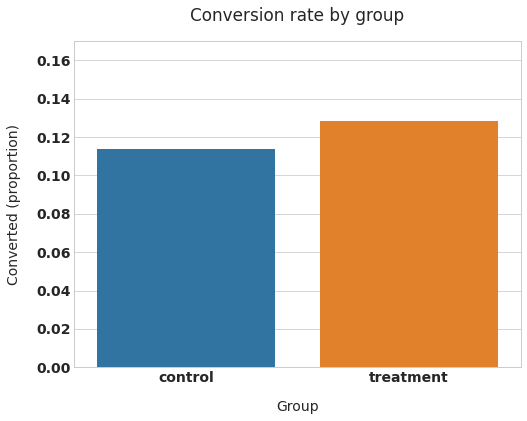

In [15]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

Conversion rate cukup mirip dan ada kenaikan yang cukup bila dibandingkan desain lama, yaitu sekitar 1,4%. Kita perlu mengecek kembali apakah perbedaannya signifikan secara statistik dengan menguji hipotesis.

***
## 4. Uji hipotesis

In [16]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [17]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [18]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -1.39
p-value: 0.164
ci 95% for control group: [0.099, 0.128]
ci 95% for treatment group: [0.113, 0.143]


***
## 5. Menarik Kesimpulan

Karena nilai $p$-value=0.164 yang mana lebih tinggi sedikit dari nilai $\alpha$=0.05, kita tidak dapat menolak null hipotesis $H_0$, yang artinya desain baru tidak menunjukkan kinerja yang berbeda secara signifikan dengan desain lama. Atau dari angka yang didapat, perbedaan nilai 1,4% bernilai kurang signifikan.

Akan tetapi, nilai yang didapat menunjukkan bahwa adanya kemungkinan desain baru bekerja dengan baik karena desain baru memiliki interval conversion rate (0,113 - 0,143) yang berarti:
1. Itu tidak masuk dalam baseline 11%
2. Itu masuk dalam target conversion rate 14%

Oleh karena itu, desain baru masih bisa dipertimbangkan lebih lanjut karena hanya sedikit tidak signifikan.

## Seluruh Dataset

Bagaimana jika menggunakan seluruh data? Apakah dapat menarik kesimpulan dengan lebih baik?

In [19]:
df.shape

(286690, 5)

In [20]:
conversion_rates = df.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.120,0.325,0.001
treatment,0.119,0.323,0.001


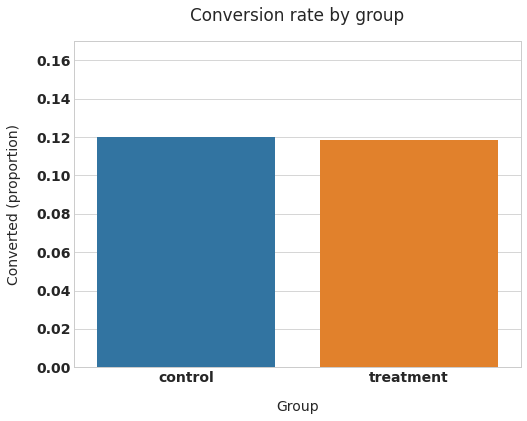

In [21]:
plt.figure(figsize=(8,6))

sns.barplot(x=df['group'], y=df['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

In [22]:
control_results = df[df['group'] == 'control']['converted']
treatment_results = df[df['group'] == 'treatment']['converted']

In [23]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.19
p-value: 0.232
ci 95% for control group: [0.118, 0.122]
ci 95% for treatment group: [0.117, 0.120]


Karena nilai $p$-value=0.232 yang mana lebih tinggi dari nilai $\alpha$=0.05, kita tidak dapat menolak null hipotesis $H_0$, yang artinya desain baru tidak menunjukkan kinerja yang berbeda secara signifikan dengan desain lama.

Nilai conversion rate pada desain lama justru lebih tinggi dibandingkan conversion rate desain baru pada keseluruhan dataset.

Selain itu, nilai yang didapat menunjukkan bahwa adanya desain baru memiliki interval conversion rate (0,117 - 0,120) yang berarti tidak sesuai dengan ekspektasi yanng bernilai 0,14.

Ini semakin meyakinkan kita bahwa desain baru tidak meningkatkan conversion rate dari website.

Berdasarkan pengujian ini, kita jadi lebih mengerti bahwa dengan menggunakan data yang lebih besar, kita lebih mengetahui secara presisi dan benar untuk merepresentasikan keseluruhan data. Namun hal ini perlu dipertimbangkan terkait waktu dan biayanya.